In [2]:
import sqlite3
import pandas as pd
import plotly.express as px
import sys
from plotly.subplots import make_subplots
import plotly.graph_objects as go

sys.path.append('../')
from functions_env import DB_PATH


conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

In [3]:
# Load individuals Main Informations
df_individual = pd.read_sql_query("SELECT * FROM individuals_main_information", conn)
df_individual = df_individual[['individual_wikidata_id', 'birthyear']]

df_individual = df_individual[~df_individual['birthyear'].isna()]
df_individual['decade'] = df_individual['birthyear'].apply(lambda x : int(x/10)*10)

In [4]:
# Load invividuals Regions
df_individual_region = pd.read_sql_query("SELECT * FROM individuals_regions", conn)
df_individual_region = df_individual_region[['individual_wikidata_id', 'region_name']].drop_duplicates()

# Load identifiers meta-data
df_identifiers = pd.read_sql_query("SELECT * FROM identifiers", conn)
df_identifiers['country_name'][df_identifiers['country_name'].isna()]=''
df_identifiers['identifier_name'] = df_identifiers.apply(lambda x : x['identifier_name'] + ' ('  + x['country_name'] + ')' if x['country_name']!='' else x['identifier_name'], axis=1)
df_identifiers = df_identifiers.drop(['country_wikidata_id', 'count_records', 'identifier_url'], axis=1).drop_duplicates()
df_identifiers = df_identifiers.drop(['country_name', 'identifier_name_country'], axis=1).drop_duplicates()


/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_79373/808557147.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_identifiers['country_name'][df_identifiers['country_name'].isna()]=''


In [5]:

#df_country =  pd.read_sql_query("SELECT * FROM country_continent", conn)
#df_country = df_country[['country_name', 'continent_name']]
#df_country = df_country.drop_duplicates('country_name', keep='first')
#df_identifiers = pd.merge(df_identifiers, df_country, on = 'country_name', how = 'left')



In [6]:
# Load infirmation about individuals and identifiers
df_ind_identifiers = pd.read_sql_query("SELECT * FROM individual_identifiers", conn)
df_ind_identifiers = df_ind_identifiers.drop('identifier_name', axis=1)
df_ind_identifiers = pd.merge(df_ind_identifiers, df_identifiers, on = 'identifiers_wikidata_id', how = 'left')

# Freebase is now mixed with Google ID
df_ind_identifiers['identifier_name'][df_ind_identifiers['identifier_name']=='Freebase ID'] = 'Google Knowledge Graph ID'
df_ind_identifiers['identifiers_wikidata_id'][df_ind_identifiers['identifiers_wikidata_id']=='P646'] = 'P2671'

# Mix the two GND
df_ind_identifiers['identifier_name'][df_ind_identifiers['identifier_name']=='Deutsche Biographie (GND) ID (Germany)'] = 'GND ID (Germany)'
df_ind_identifiers['identifiers_wikidata_id'][df_ind_identifiers['identifiers_wikidata_id']=='P7902'] = 'P227'

# Clean wrong objects
df_ind_identifiers = df_ind_identifiers[~df_ind_identifiers['individual_name'].str.contains('Painter')]

# Remove superceded
df_ind_identifiers = df_ind_identifiers[~df_ind_identifiers['identifier_name'].str.contains('superceded')]
df_ind_identifiers = df_ind_identifiers[~df_ind_identifiers['identifier_name'].str.contains('obsolete')]

# Drop duplicated after mergeing GND and Freebase
df_ind_identifiers = df_ind_identifiers.drop_duplicates()

In [7]:
# Merge everything

df_final = pd.merge(df_individual, df_ind_identifiers, on = 'individual_wikidata_id')
df_final = pd.merge(df_final, df_individual_region, on = 'individual_wikidata_id')

In [8]:
df_fig = df_final[['individual_wikidata_id', 'decade', 'identifier_name', 'region_name']]
df_fig = df_fig.groupby(['identifier_name', 'region_name', 'decade'])['individual_wikidata_id'].count().rename("score").reset_index()


df_country_id = pd.read_sql_query("SELECT * FROM identifiers", conn)
df_country_id['country_name'][df_country_id['country_name'].isna()]=''
df_country_id['identifier_name'] = df_country_id.apply(lambda x : x['identifier_name'] + ' ('  + x['country_name'] + ')' if x['country_name']!='' else x['identifier_name'], axis=1)
df_country_id = df_country_id[['identifier_name', 'country_name']].drop_duplicates()

df_fig = pd.merge(df_fig, df_country_id, on = 'identifier_name')


/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_79373/1539816987.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country_id['country_name'][df_country_id['country_name'].isna()]=''


In [9]:
def make_figure(df_graph_bis, region_name, min_decade = 1200, max_decade = 1800, top_identifiers = 5, one_id_country = False):
    
    
    df_fig = df_graph_bis[df_graph_bis['region_name']==region_name]
    df_fig = df_fig[df_fig['decade']<=max_decade]
    df_fig = df_fig[df_fig['decade']>=min_decade]
    
    if one_id_country:
        
        df_fig = df_fig[df_fig['country_name']!='']
        one_id_country = df_fig.groupby(['country_name', 'identifier_name'])['score'].sum().reset_index()
        one_id_country = one_id_country.sort_values(['country_name', 'score'], ascending=(False, False))
        one_id_country = one_id_country.groupby('country_name').head(1)
        one_id_country = list(one_id_country['identifier_name'])
        df_fig = df_fig[df_fig['identifier_name'].isin(one_id_country)]
        
    top_ids = df_fig.groupby(['identifier_name'])['score'].sum().reset_index().sort_values('score', ascending=False)

    #top_ids = top_ids[top_ids['identifier_name']!='all_identifiers']
    top_ids = list(top_ids['identifier_name'][:top_identifiers])
    df_fig = df_fig[df_fig['identifier_name'].isin(top_ids)]
    df_fig_mean = df_fig.groupby(['decade'])['score'].mean().reset_index()
    df_fig_mean['identifier_name'] = 'average'

    #df_fig = pd.concat([df_fig, df_fig_mean])

    fig = px.line(df_fig, x = 'decade', y = 'score', color = 'identifier_name',
                  width = 1200, 
                  height = 600, 
                  title = region_name, 
                  template = 'simple_white',
                  category_orders={'identifier_name': top_ids}) 
                  #line_shape='spline')


    #fig.update_layout(legend=dict(title=dict(text='Top 5 Immaterial Production')))
    fig.update_traces(opacity=0.25)

    fig2 = px.line(df_fig_mean, x = 'decade', y = 'score',color = 'identifier_name',
              width = 1200, 
              height = 600, 
              title = region_name, 
              template = 'simple_white')
              #line_shape='spline')

    fig2.update_traces(line=dict(width=3))
    fig3 = go.Figure(data=fig.data + fig2.data)
    fig3.update_layout(xaxis_title='', yaxis_title='Number of Individuals',  
                       template = 'simple_white',  
                       width = 1300, 
                       height = 800,
                      title = region_name)

# Update the layout with the category order


    #ig3.for_each_trace(lambda t: t.update(name=legend_order.index(t.name)))
    fig3.update_layout(legend=dict(title=dict(text='Identifiers')))
    #fig3.update_layout(category_orders={'Identifiers': top_ids})
    fig3.update_layout(xaxis=dict(dtick=100))
    #fig3.update_layout(title_text=region_name)

    return fig3, df_fig


df_fig_fifty = df_fig.copy()
df_fig_fifty['decade'] = df_fig_fifty['decade'].apply(lambda x : round(x/50)*50)
df_fig_fifty = df_fig_fifty.groupby(['identifier_name', 'country_name', 'region_name', 'decade'])['score'].sum().reset_index()

region_name = 'Italy'

fig_italy, df_fig_italy = make_figure(df_fig_fifty, 
                   region_name = region_name, 
                   min_decade = -300, 
                   max_decade = 500, 
                   top_identifiers = 20,
                  one_id_country = True)

fig_italy.show()
fig_italy.write_image(f"figures/italy_identifiers.png", scale=7)

In [10]:
df_corr = df_fig_italy.pivot(index ='decade', columns = 'identifier_name', values = 'score')
df_corr = df_corr.fillna(0)
df_corr.corr().stack().mean()

0.8901595863749558

In [11]:
fig_greek, df_fig_greek = make_figure(df_fig_fifty, region_name = 'Greek World', min_decade = -800, max_decade = 500, top_identifiers = 20,
                  one_id_country = True)

fig_greek.write_image(f"figures/greek_identifiers.png", scale=7)
fig_greek.show()

In [12]:
df_corr = df_fig_greek.pivot(index ='decade', columns = 'identifier_name', values = 'score')
df_corr = df_corr.fillna(0)
df_corr.corr().stack().mean()

0.8321062197606176

In [13]:
fig, df_fig = make_figure(df_fig_fifty, region_name = 'Chinese world', min_decade = -800, max_decade = 1800, top_identifiers = 20,
                  one_id_country = True)

fig.write_image(f"figures/china_identifiers.png", scale=7)
fig.show()

## Count catalogs per country and continents

In [14]:
list(set(df_fig_fifty.region_name))

['Low countries',
 'Western Europe',
 'Greece',
 'Germany',
 'Belgium',
 'Northern China',
 'France',
 'Switzerland',
 'Iceland',
 'Northwestern Europe',
 'Slav world',
 'Finland',
 'mediterranean World',
 'Northern Japan',
 'Ottoman Turkey',
 'Japan',
 'Italy',
 'Persian world',
 'Spain',
 'Indian world',
 'Muslim world',
 'Central Europe',
 'British Islands',
 'Netherlands',
 'Ireland',
 'Southern France',
 'Northern Italy',
 'Eastern Europe',
 'Southern Italy',
 'Nordic countries',
 'United Kingdom',
 'Latin World',
 'Denmark',
 'Southern Japan',
 'Sweden',
 'Portugal',
 'Northern France',
 'Ottoman world',
 'Balkans',
 'Northern India',
 'Austria',
 'Southern China',
 'Southern India',
 'Arabian peninsula',
 'Southwestern Europe',
 'South East Asia',
 'Chinese world',
 'Yangtze',
 'Norway',
 'Korea',
 'Greek World',
 'German world',
 'Arabic world']

In [15]:
fig, df_fig = make_figure(df_fig_fifty, region_name = 'Muslim world', min_decade = 500, max_decade = 1800, top_identifiers = 20,
                  one_id_country = True)

fig.write_image(f"figures/mena_identifiers.png", scale=7)
fig.show()

In [16]:
df_corr = df_fig.pivot(index ='decade', columns = 'identifier_name', values = 'score')
df_corr = df_corr.fillna(0)
df_corr.corr().stack().mean()

0.7926302281522886

In [17]:
fig, df_fig = make_figure(df_fig_fifty, region_name = 'Low countries', min_decade = 1200, max_decade = 1800, top_identifiers = 20,
                  one_id_country = True)

fig.write_image(f"figures/low_countries_identifiers.png", scale=7)
fig.show()

In [18]:
df_corr = df_fig_italy.pivot(index ='decade', columns = 'identifier_name', values = 'score')
df_corr = df_corr.fillna(0)
df_corr.corr().stack().mean()

0.8901595863749558

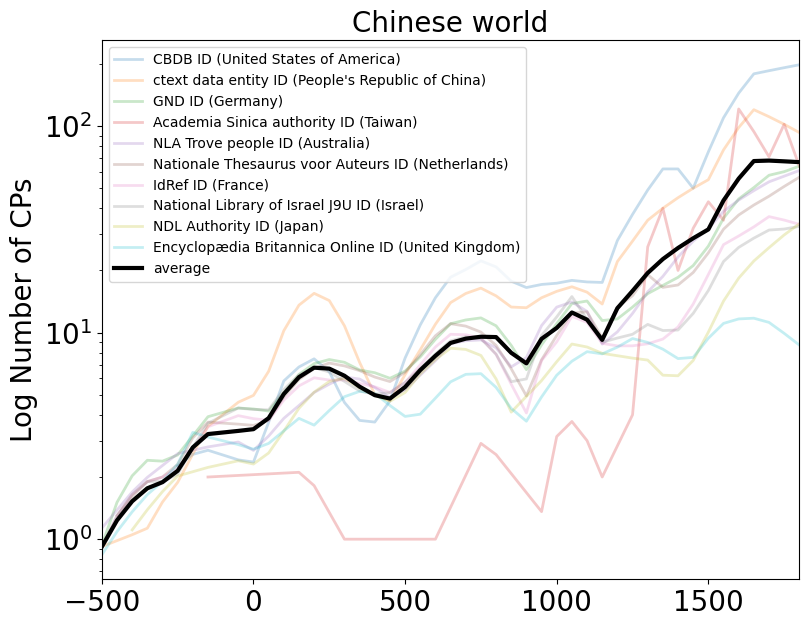

0.899587324385561

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm

def make_figure(df_graph_bis, region_name, min_decade=-500, max_decade=1800, top_identifiers=5, one_id_country=False):
    df_fig = df_graph_bis[df_graph_bis['region_name'] == region_name]
    df_fig = df_fig[(df_fig['decade'] <= max_decade) & (df_fig['decade'] >= min_decade)]
    
    if one_id_country:
        df_fig = df_fig[df_fig['country_name'] != '']
        one_id_country = df_fig.groupby(['country_name', 'identifier_name'])['score'].sum().reset_index()
        one_id_country = one_id_country.sort_values(['country_name', 'score'], ascending=(False, False))
        one_id_country = one_id_country.groupby('country_name').head(1)
        one_id_country = list(one_id_country['identifier_name'])
        df_fig = df_fig[df_fig['identifier_name'].isin(one_id_country)]
    
    top_ids = df_fig.groupby('identifier_name')['score'].sum().reset_index().sort_values('score', ascending=False)
    top_ids = list(top_ids['identifier_name'][:top_identifiers])
    df_fig = df_fig[df_fig['identifier_name'].isin(top_ids)]
    
    df_fig_mean = df_fig.groupby('decade')['score'].mean().reset_index()
    df_fig_mean['identifier_name'] = 'average'

    plt.figure(figsize=(9, 7))


    # Plot LOWESS regression for each top identifier with alpha
    for identifier in top_ids:
        subset = df_fig[df_fig['identifier_name'] == identifier]
        lowess = sm.nonparametric.lowess(subset['score'], subset['decade'], frac=0.15)
        plt.plot(lowess[:, 0], lowess[:, 1], label=identifier, linewidth=2, alpha=0.25)

    # Calculate and plot LOWESS for the average score without alpha
    lowess_mean = sm.nonparametric.lowess(df_fig_mean['score'], df_fig_mean['decade'], frac=0.15)
    plt.plot(lowess_mean[:, 0], lowess_mean[:, 1], label='average', linewidth=3, color='black')

    # Set the title and labels
    plt.title(region_name, fontsize=20)
    plt.xlabel('', fontsize=20)
    plt.ylabel('Log Number of CPs', fontsize=20)
    
    # Set the scale, limits, and ticks
    plt.yscale('log')
    plt.xticks(np.arange(min_decade, max_decade + 1, 500), fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlim(min_decade, max_decade)
    
    # Add the legend and grid
    plt.legend(title='', fontsize=10, title_fontsize=15)
    plt.grid(False)

    # Save the figure
    plt.savefig(f"figures/{region_name.lower()}_identifiers.png", dpi=300)
    
    plt.show()

    return df_fig

# Example usage:
# Assuming df_fig_fifty is already defined and contains the data

region_name = 'Chinese world'

df_fig = make_figure(df_fig_fifty,
            region_name=region_name,
            min_decade=-500,
            max_decade=1800,
            top_identifiers=10,
            one_id_country=True)


df_corr = df_fig.pivot(index ='decade', columns = 'identifier_name', values = 'score')
df_corr = df_corr.fillna(0)
df_corr.corr().stack().mean()



,identifier_name,country_name,region_name,decade,score
0,1914-1918-Online ID,,Arabic world,1850,1
1,1914-1918-Online ID,,Austria,1850,1
2,1914-1918-Online ID,,Belgium,1850,1
3,1914-1918-Online ID,,British Islands,1850,2
4,1914-1918-Online ID,,Central Europe,1850,3
...,...,...,...,...,...
242937,Český hudební slovník osob a institucí ID (Cze...,Czech Republic,Western Europe,1650,4
242938,Český hudební slovník osob a institucí ID (Cze...,Czech Republic,Western Europe,1700,16
242939,Český hudební slovník osob a institucí ID (Cze...,Czech Republic,Western Europe,1750,31
242940,Český hudební slovník osob a institucí ID (Cze...,Czech Republic,Western Europe,1800,26
